# **Setup**

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 16.3MB/s 
     |████████████████████████████████| 8.7MB 36.2MB/s 
  Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# General
from google.colab import files
import pandas as pd
import math
import numpy as np


# Data Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline([
                     ('std_scaler', StandardScaler()),
    ])

# Machine Learning 
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

import tensorflow as tf


import lightgbm as lgb

# Plotting
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Utils
from feature_utils import (
    week_of_month,
    df_from_cartesian_product,
    combine_features,
)

# Warning
import warnings
warnings.filterwarnings("ignore")

# **Basic Data Processing**

In [ ]:
uploaded = files.upload()

Saving MARCEMET.csv to MARCEMET (1).csv


In [ ]:
# Read the CSV file and drop irrelavant data.

tags = ['Station Code', 'isSWMP', 'Time Stamp', 'Historical', 'Provisional Plus', 'Frequency', 'F_record', 'ATemp', 'F_ATemp', 'RH', 'F_RH', 'BP',
        'F_BP', 'WSpd', 'F_WSpd', 'MaxWSpd', 'F_MaxWSpd', 'MaxWSpdT', 'Wdir', 'F_Wdir', 'SDWDir', 'F_SDWDir', 'TotPAR', 'F_TotPAR', 'TotPrcp', 'F_TotPrcp']
original = pd.read_csv('MARCEMET.csv', sep=',', names=tags)
original = original.iloc[3:350691]
data = original.drop(['Station Code', 'isSWMP', 'Time Stamp', 'Historical', 'Provisional Plus', 'Frequency', 'F_record', 'F_ATemp', 'F_RH', 'F_BP', 'F_WSpd', 'F_MaxWSpd', 'F_Wdir', 
                  'MaxWSpdT', 'F_SDWDir', 'F_TotPAR', 'F_TotPrcp'], axis=1)
data = data.apply(pd.to_numeric)
data

,ATemp,RH,BP,WSpd,MaxWSpd,Wdir,SDWDir,TotPAR,TotPrcp
3,27.0,81.0,1014.0,5.9,7.2,158.0,7.0,NaN,0.0
4,27.0,81.0,1014.0,6.5,7.4,154.0,5.0,NaN,0.0
5,26.9,83.0,1014.0,5.6,7.0,157.0,6.0,NaN,0.0
6,26.9,84.0,1014.0,5.7,7.0,147.0,8.0,NaN,0.0
7,26.9,84.0,1014.0,6.1,7.3,145.0,6.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...
350686,-24.2,14.0,1017.0,2.5,2.9,50.0,6.0,0.0,0.0
350687,-24.2,14.0,1017.0,2.4,3.1,40.0,6.0,0.0,0.0
350688,-23.9,14.0,1017.0,2.9,3.8,53.0,9.0,0.0,0.0
350689,-23.9,14.0,1017.0,2.8,3.8,44.0,8.0,0.0,0.0


In [ ]:
# Add a new column for time stamp (represented as integers)
data['Time_Stamp'] = range(350688)
data

,ATemp,RH,BP,WSpd,MaxWSpd,Wdir,SDWDir,TotPAR,TotPrcp,Time_Stamp
3,27.0,81.0,1014.0,5.9,7.2,158.0,7.0,NaN,0.0,0
4,27.0,81.0,1014.0,6.5,7.4,154.0,5.0,NaN,0.0,1
5,26.9,83.0,1014.0,5.6,7.0,157.0,6.0,NaN,0.0,2
6,26.9,84.0,1014.0,5.7,7.0,147.0,8.0,NaN,0.0,3
7,26.9,84.0,1014.0,6.1,7.3,145.0,6.0,NaN,0.0,4
...,...,...,...,...,...,...,...,...,...,...
350686,-24.2,14.0,1017.0,2.5,2.9,50.0,6.0,0.0,0.0,350683
350687,-24.2,14.0,1017.0,2.4,3.1,40.0,6.0,0.0,0.0,350684
350688,-23.9,14.0,1017.0,2.9,3.8,53.0,9.0,0.0,0.0,350685
350689,-23.9,14.0,1017.0,2.8,3.8,44.0,8.0,0.0,0.0,350686


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa393b3a198>,
      dtype=object)

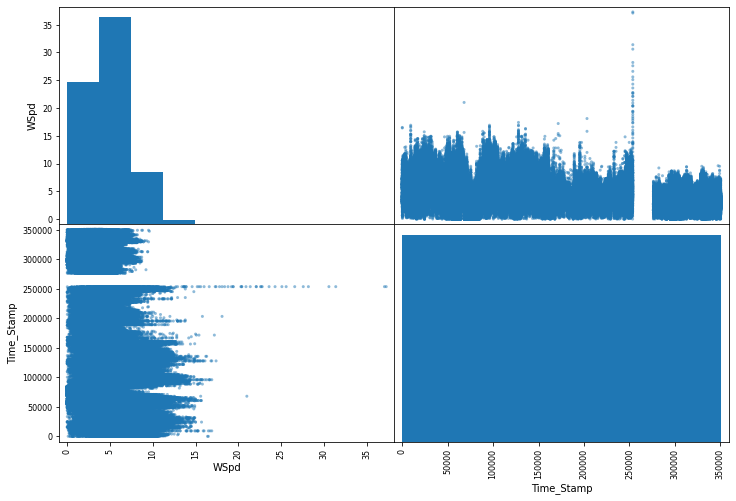

In [ ]:
scatter_matrix(data[['WSpd', 'Time_Stamp']], figsize=(12, 8))

In [ ]:
# Missing data
incomplete_rows = data[data.isnull().any(axis=1)]
incomplete_rows

,ATemp,RH,BP,WSpd,MaxWSpd,Wdir,SDWDir,TotPAR,TotPrcp,Time_Stamp
3,27.0,81.0,1014.0,5.9,7.2,158.0,7.0,NaN,0.0,0
4,27.0,81.0,1014.0,6.5,7.4,154.0,5.0,NaN,0.0,1
5,26.9,83.0,1014.0,5.6,7.0,157.0,6.0,NaN,0.0,2
6,26.9,84.0,1014.0,5.7,7.0,147.0,8.0,NaN,0.0,3
7,26.9,84.0,1014.0,6.1,7.3,145.0,6.0,NaN,0.0,4
...,...,...,...,...,...,...,...,...,...,...
349382,NaN,100.0,1014.0,1.1,1.6,127.0,9.0,1054.2,0.0,349379
349383,NaN,100.0,1014.0,1.2,2.2,138.0,29.0,1143.9,0.0,349380
349384,NaN,100.0,1014.0,0.8,1.4,268.0,21.0,1227.4,0.0,349381
349385,NaN,100.0,1014.0,0.5,1.0,280.0,9.0,1311.1,0.0,349382


In [ ]:
# data['WSpd'].fillna(method='ffill', inplace=True)
data.fillna(method='ffill', inplace=True)

In [ ]:
data.fillna(method='bfill', inplace=True)

# **Machine Learning by ARIMA**

In [ ]:
prepare = data.copy()
prepare.iloc[:, 3] = prepare.iloc[:, 3] + 1
prepare

,ATemp,RH,BP,WSpd,MaxWSpd,Wdir,SDWDir,TotPAR,TotPrcp,Time_Stamp
3,27.0,81.0,1014.0,6.9,7.2,158.0,7.0,NaN,0.0,0
4,27.0,81.0,1014.0,7.5,7.4,154.0,5.0,NaN,0.0,1
5,26.9,83.0,1014.0,6.6,7.0,157.0,6.0,NaN,0.0,2
6,26.9,84.0,1014.0,6.7,7.0,147.0,8.0,NaN,0.0,3
7,26.9,84.0,1014.0,7.1,7.3,145.0,6.0,NaN,0.0,4
...,...,...,...,...,...,...,...,...,...,...
350686,-24.2,14.0,1017.0,3.5,2.9,50.0,6.0,0.0,0.0,350683
350687,-24.2,14.0,1017.0,3.4,3.1,40.0,6.0,0.0,0.0,350684
350688,-23.9,14.0,1017.0,3.9,3.8,53.0,9.0,0.0,0.0,350685
350689,-23.9,14.0,1017.0,3.8,3.8,44.0,8.0,0.0,0.0,350686


In [ ]:
prepare['logWSpd'] = prepare.WSpd.apply(lambda x: math.log(x))
prepare = prepare.drop('WSpd', axis=1)
prepare

,ATemp,RH,BP,MaxWSpd,Wdir,SDWDir,TotPAR,TotPrcp,Time_Stamp,logWSpd
3,27.0,81.0,1014.0,7.2,158.0,7.0,NaN,0.0,0,1.931521
4,27.0,81.0,1014.0,7.4,154.0,5.0,NaN,0.0,1,2.014903
5,26.9,83.0,1014.0,7.0,157.0,6.0,NaN,0.0,2,1.887070
6,26.9,84.0,1014.0,7.0,147.0,8.0,NaN,0.0,3,1.902108
7,26.9,84.0,1014.0,7.3,145.0,6.0,NaN,0.0,4,1.960095
...,...,...,...,...,...,...,...,...,...,...
350686,-24.2,14.0,1017.0,2.9,50.0,6.0,0.0,0.0,350683,1.252763
350687,-24.2,14.0,1017.0,3.1,40.0,6.0,0.0,0.0,350684,1.223775
350688,-23.9,14.0,1017.0,3.8,53.0,9.0,0.0,0.0,350685,1.360977
350689,-23.9,14.0,1017.0,3.8,44.0,8.0,0.0,0.0,350686,1.335001


In [ ]:
train_set = prepare.iloc[0:30000, 9]
train_set

3        1.931521
4        2.014903
5        1.887070
6        1.902108
7        1.960095
           ...   
29998    2.163323
29999    2.091864
30000    2.116256
30001    2.151762
30002    2.219203
Name: logWSpd, Length: 30000, dtype: float64

In [ ]:
test_set = prepare.iloc[30000: 30300, 9]
test_set

30003    2.272126
30004    2.197225
30005    2.197225
30006    2.186051
30007    2.230014
           ...   
30298    2.116256
30299    2.151762
30300    2.104134
30301    2.066863
30302    2.014903
Name: logWSpd, Length: 300, dtype: float64

In [ ]:
# Parameters of ARIMA model
params = {
    "seasonal": True,
    "start_p": 0,
    "start_q": 0,
    "max_p": 5,
    "max_q": 5,
    "m": 52,
}

In [ ]:
model = auto_arima(
    train_set,
    seasonal=params["seasonal"],
    # start_p=params["start_p"],
    # start_q=params["start_q"],
    # max_p=params["max_p"],
    # max_q=params["max_q"],
    stepwise=True,
)

model.fit(train_set)

ARIMA(maxiter=50, method='lbfgs', order=(4, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                30000
Model:               SARIMAX(4, 1, 2)   Log Likelihood               24407.655
Date:                Mon, 29 Jun 2020   AIC                         -48799.310
Time:                        23:16:42   BIC                         -48732.839
Sample:                             0   HQIC                        -48777.982
                              - 30000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.495e-06   2.11e-05     -0.165      0.869   -4.49e-05    3.79e-05
ar.L1          0.1959      0.023      8.683      0.000       0.152       0.240
ar.L2          0.7418      0.024     31.351      0.000       0.695       0.788
ar.L3         -0.1135      0.004    -29.660      0.000      -0.121      -0.106
ar.L4          0.0743      0.004     20.880      0.000       0.067       0.081
ma.L1         -0.1250      0.023     -5.539      0.000      -0.169      -0.081
ma.L2         -0.8465      0.022    -38.183      0.000      -0.890      -0.803
sigma2         0.0115   3.59e-05    320.826      0.000       0.011       0.012
===================================================================================
Ljung-Box (Q):                      140.19   Jarque-Bera (JB):            270459.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.69
Prob(H) (two-sided):                  0.67   Kurtosis:                        17.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

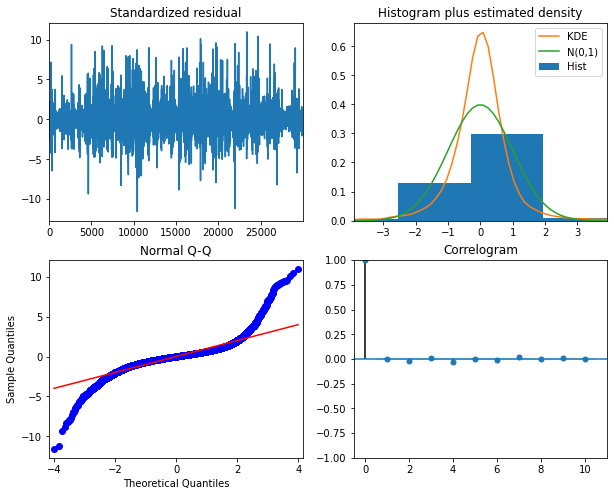

In [ ]:
model.plot_diagnostics(figsize=(10, 8))
plt.show()

In [ ]:
preds = model.predict(n_periods=300)

In [ ]:
pred_df = pd.DataFrame({'Predictions': preds})

In [ ]:
actual_df = pd.DataFrame({'Actuals': test_set})

In [ ]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
metric_value = MAPE(test_set, preds)
metric_value

16.635722323547753

# **Machine Learning with LightGBM**

In [ ]:
data

,ATemp,RH,BP,WSpd,MaxWSpd,Wdir,SDWDir,TotPAR,TotPrcp,Time_Stamp
3,27.0,81.0,1014.0,5.9,7.2,158.0,7.0,21.7,0.0,0
4,27.0,81.0,1014.0,6.5,7.4,154.0,5.0,21.7,0.0,1
5,26.9,83.0,1014.0,5.6,7.0,157.0,6.0,21.7,0.0,2
6,26.9,84.0,1014.0,5.7,7.0,147.0,8.0,21.7,0.0,3
7,26.9,84.0,1014.0,6.1,7.3,145.0,6.0,21.7,0.0,4
...,...,...,...,...,...,...,...,...,...,...
350686,-24.2,14.0,1017.0,2.5,2.9,50.0,6.0,0.0,0.0,350683
350687,-24.2,14.0,1017.0,2.4,3.1,40.0,6.0,0.0,0.0,350684
350688,-23.9,14.0,1017.0,2.9,3.8,53.0,9.0,0.0,0.0,350685
350689,-23.9,14.0,1017.0,2.8,3.8,44.0,8.0,0.0,0.0,350686


In [ ]:
# lags = np.arange(2, 10)
# window_size = 40
# used_columns = ['ATemp', 'RH', 'BP', 'WSpd', 'Wdir', 'SDWDir', 'TotPAR', 'TotPrcp', 'Time_Stamp']

# features = data.apply(lambda x: combine_features(x, [''], lags, window_size, used_columns))
train = data.iloc[0:30000, :].drop('MaxWSpd', axis=1)
test = data.iloc[30000: 30300, :].drop('MaxWSpd', axis=1)

In [ ]:
train = pipeline.fit_transform(train)
test = pipeline.fit_transform(test)

In [ ]:
# train_prepared = pd.DataFrame({'ATemp': train[:, 0], 'RH': train[:, 1], 'BP': train[:, 2], 'WSpd': train[:, 3], 'Wdir': train[:, 4], 'SDWDir': train[:, 5],
#                                'TotPAR': train[:, 6], 'TotPrcp': train[:, 7], 'Time_Stamp': train[:, 8]})

# test_prepared = pd.DataFrame({'ATemp': test[:, 0], 'RH': test[:, 1], 'BP': test[:, 2], 'WSpd': test[:, 3], 'Wdir': test[:, 4], 'SDWDir': test[:, 5],
#                                'TotPAR': test[:, 6], 'TotPrcp': test[:, 7], 'Time_Stamp': test[:, 8]})

In [ ]:
dtrain = lgb.Dataset(train.drop('WSpd', axis=1), label=train['WSpd'])

params = {
    "objective": "mape",
    "learning_rate": 0.05,
    "num_rounds": 800,
    "early_stopping_rounds": 700,
    "num_leaves": 500,
    "max_bin": 300,
    "bagging_fraction": 0.87,
    "bagging_freq": 19,
}

bst = lgb.train(params, dtrain, valid_sets=[dtrain], verbose_eval=50)

Training until validation scores don't improve for 700 rounds.
[50]	training's mape: 0.150097
[100]	training's mape: 0.113632
[150]	training's mape: 0.100647
[200]	training's mape: 0.0928672
[250]	training's mape: 0.0874366
[300]	training's mape: 0.0834017
[350]	training's mape: 0.080878
[400]	training's mape: 0.0788234
[450]	training's mape: 0.0765605
[500]	training's mape: 0.0747096
[550]	training's mape: 0.0732633
[600]	training's mape: 0.0720992
[650]	training's mape: 0.0710342
[700]	training's mape: 0.0700692
[750]	training's mape: 0.0692839
[800]	training's mape: 0.0685831
Did not meet early stopping. Best iteration is:
[800]	training's mape: 0.0685831


In [ ]:
def predict(df, model, target_col, idx_cols, integer_output=True):
    """Predict target variable with a trained LightGBM model.
    
    Args: 
        df (pandas.DataFrame): Dataframe including all needed features
        model (lightgbm.Booster): Trained LightGBM booster model
        target_col (str): Name of the target column
        idx_col (list[str]): List of the names of the index columns, e.g. ["store", "brand", "week"]
        integer_output (bool): It it is True, the forecast will be rounded to an integer
        
    Returns:
        pandas.DataFrame including the predictions of the target variable 
    """
    if target_col in df.columns:
        df = df.drop(target_col, axis=1)
    predictions = pd.DataFrame({target_col: model.predict(df)})
    if integer_output:
        predictions[target_col] = predictions[target_col]#.apply(lambda x: round(x))
    return pd.concat([df[idx_cols].reset_index(drop=True), predictions], axis=1)

In [ ]:
preds = predict(test, bst, target_col='WSpd', idx_cols=['ATemp', 'RH', 'BP', 'Wdir', 'SDWDir', 'TotPAR', 'TotPrcp', 'Time_Stamp'])
preds

,ATemp,RH,BP,Wdir,SDWDir,TotPAR,TotPrcp,Time_Stamp,WSpd
0,24.0,91.0,1012.0,138.0,5.0,2.1,0.0,30000,8.194765
1,24.1,91.0,1012.0,139.0,4.0,2.1,0.0,30001,8.276459
2,24.2,91.0,1012.0,141.0,4.0,2.1,0.0,30002,8.301052
3,24.2,92.0,1012.0,140.0,4.0,2.1,0.0,30003,8.259837
4,24.2,92.0,1012.0,140.0,5.0,2.1,0.0,30004,8.290620
...,...,...,...,...,...,...,...,...,...
295,23.3,34.0,1018.0,111.0,5.0,2.1,0.0,30295,6.955237
296,23.3,34.0,1018.0,111.0,5.0,2.1,0.0,30296,6.955237
297,23.3,37.0,1018.0,112.0,5.0,2.1,0.0,30297,6.880487
298,23.2,40.0,1017.0,118.0,7.0,2.1,0.0,30298,6.353572


In [ ]:
metric_value = MAPE(test['WSpd'], preds['WSpd'])
metric_value

29.945763427339255

# **Machine Learning with RNN**

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
TRAIN_SPLIT = 100000
tf.random.set_seed(13)

past_history = 9600
#future_target = 96
STEP = 8

BATCH_SIZE = 256
BUFFER_SIZE = 10000

EVALUATION_INTERVAL = 200
EPOCHS = 10

In [ ]:
df = original.drop(['Station Code', 'isSWMP', 'Historical', 'Provisional Plus', 'Frequency', 'F_record', 'F_ATemp', 'F_RH', 'F_BP', 'F_WSpd', 'F_MaxWSpd', 'F_Wdir', 
                  'MaxWSpdT', 'F_SDWDir', 'F_TotPAR', 'F_TotPrcp'], axis=1)
df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df

NameError: ignored

In [ ]:
df = data.iloc[: 150000,:]
df

,ATemp,RH,BP,WSpd,MaxWSpd,Wdir,SDWDir,TotPAR,TotPrcp,Time_Stamp
3,27.0,81.0,1014.0,5.9,7.2,158.0,7.0,21.7,0.0,0
4,27.0,81.0,1014.0,6.5,7.4,154.0,5.0,21.7,0.0,1
5,26.9,83.0,1014.0,5.6,7.0,157.0,6.0,21.7,0.0,2
6,26.9,84.0,1014.0,5.7,7.0,147.0,8.0,21.7,0.0,3
7,26.9,84.0,1014.0,6.1,7.3,145.0,6.0,21.7,0.0,4
...,...,...,...,...,...,...,...,...,...,...
149998,29.0,73.0,1012.0,7.8,9.3,152.0,6.0,1723.9,0.0,149995
149999,29.0,73.0,1012.0,7.6,9.4,150.0,5.0,1755.6,0.0,149996
150000,29.0,73.0,1012.0,7.7,9.9,145.0,7.0,1763.1,0.0,149997
150001,28.8,76.0,1012.0,7.7,9.3,142.0,4.0,1805.9,0.0,149998


In [ ]:
features_considered = ['ATemp', 'RH', 'BP', 'WSpd', 'Wdir', 'SDWDir', 'TotPAR', 'TotPrcp']
features = df[features_considered]
features.index = df['Time_Stamp']
features.head()

,ATemp,RH,BP,WSpd,Wdir,SDWDir,TotPAR,TotPrcp
Time_Stamp,,,,,,,,
0,27.0,81.0,1014.0,5.9,158.0,7.0,21.7,0.0
1,27.0,81.0,1014.0,6.5,154.0,5.0,21.7,0.0
2,26.9,83.0,1014.0,5.6,157.0,6.0,21.7,0.0
3,26.9,84.0,1014.0,5.7,147.0,8.0,21.7,0.0
4,26.9,84.0,1014.0,6.1,145.0,6.0,21.7,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3416c86a0>,
      dtype=object)

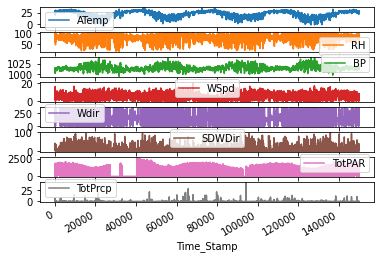

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
future_target = 720
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 3], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 3],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

NameError: ignored

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

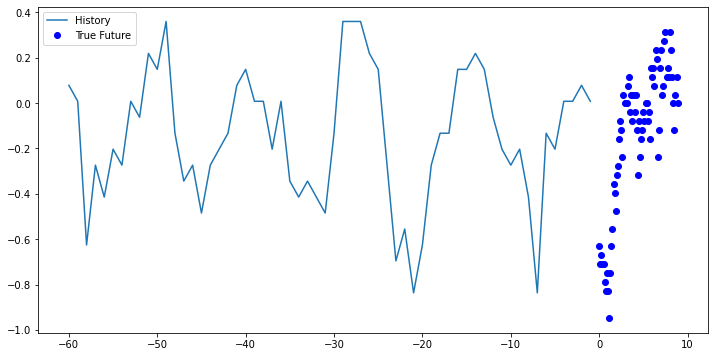

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(8,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(4, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 11s 57ms/step - loss: 0.7458 - val_loss: 0.6846
Epoch 2/10
200/200 [==============================] - 11s 56ms/step - loss: 0.6516 - val_loss: 0.6705
Epoch 3/10
200/200 [==============================] - 11s 57ms/step - loss: 0.6099 - val_loss: 0.6772
Epoch 4/10
200/200 [==============================] - 11s 56ms/step - loss: 0.5890 - val_loss: 0.6730
Epoch 5/10
200/200 [==============================] - 11s 57ms/step - loss: 0.5903 - val_loss: 0.6686
Epoch 6/10
200/200 [==============================] - 11s 56ms/step - loss: 0.5768 - val_loss: 0.6654
Epoch 7/10
200/200 [==============================] - 11s 57ms/step - loss: 0.5583 - val_loss: 0.6497
Epoch 8/10
200/200 [==============================] - 11s 56ms/step - loss: 0.5512 - val_loss: 0.6329
Epoch 9/10
200/200 [==============================] - 11s 55ms/step - loss: 0.5504 - val_loss: 0.6171
Epoch 10/10
200/200 [==============================] - 11s 56ms/step - loss: 0.530

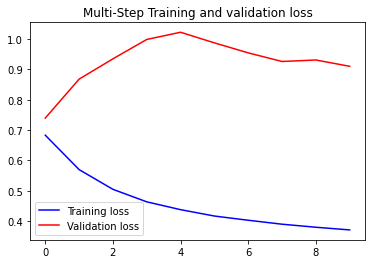

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')